# *CNN Tensorflow*

Avantages de TensorFlow par rapport à PyTorch :

1.   TensorFlow est largement utilisé dans l'industrie et bénéficie d'une solide communauté de développeurs et de support continu de Google.

2.   Déploiement Multi-plateforme : TensorFlow offre des options robustes pour le déploiement sur diverses plateformes, y compris mobiles (TensorFlow Lite) et web (TensorFlow.js).

3. API de Haut Niveau : tf.keras simplifie la construction de modèles
avec une syntaxe intuitive, adaptée aux débutants en deep learning.

4. Écosystème Complet : TensorFlow comprend une gamme d'outils pour le prétraitement des données (tf.data), la visualisation (TensorBoard) et le calcul distribué (tf.distribute).

5. Intégration avec TensorFlow Serving : Facilite le déploiement de modèles en production avec une gestion efficace des versions.

Inconvénients de TensorFlow par rapport à PyTorch :

1. Complexité Initiale : La configuration initiale et la compréhension des graphes de calcul peuvent sembler complexes aux débutants.

2. Flexibilité Limitée des Graphes : Personnaliser le graphe de calcul nécessite une connaissance approfondie de l'API TensorFlow.

# *Validation*

In [24]:
import os
from PIL import Image
import itertools

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


# *Création du Dataset*

In [25]:
def create_dataframe(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return pd.DataFrame({'filepaths': filepaths, 'label': labels})

# Chemins des datasets
train_data_path = '/kaggle/input/zoidberg-dataset/ZoidBerg2.0 - T-Dev-810/chest_Xray/train'
valid_data_dir = '/kaggle/input/zoidberg-dataset/ZoidBerg2.0 - T-Dev-810/chest_Xray/val'
test_data_dir = '/kaggle/input/zoidberg-dataset/ZoidBerg2.0 - T-Dev-810/chest_Xray/test'

# Créer les dataframes
train_df = create_dataframe(train_data_path)
valid_df = create_dataframe(valid_data_dir)
test_df = create_dataframe(test_data_dir)

# *Data Augmentation*

Le modèle est une architecture convolutionnelle (CNN) classique pour la classification d'images. Il comprend des couches convolutionnelles avec activation ReLU suivies de max pooling pour la réduction des dimensions. Les couches fully-connected à la fin du réseau permettent la classification multi-classe

In [26]:
def balance_classes(df):
    class_counts = df['label'].value_counts()
    majority_class = class_counts.idxmax()
    minority_class = class_counts.idxmin()
    
    majority_df = df[df['label'] == majority_class]
    minority_df = df[df['label'] == minority_class]
    
    if len(majority_df) > len(minority_df):
        minority_df_resampled = resample(minority_df, replace=True, n_samples=len(majority_df), random_state=42)
        df_balanced = pd.concat([majority_df, minority_df_resampled])
    else:
        df_balanced = df
    
    return df_balanced

# Équilibrer les datasets Normal/Pneumonie
train_df_balanced = balance_classes(train_df)
valid_df_balanced = balance_classes(valid_df)
test_df_balanced = balance_classes(test_df)

# Limitation du dataset de train à 2000 images
train_df_balanced = train_df_balanced.sample(n=1000, random_state=42)

# Vérifier la répartition des classes après équilibrage
print("Répartition des classes dans le dataset d'entraînement après équilibrage:")
print(train_df_balanced['label'].value_counts())
print("\nRépartition des classes dans le dataset de validation après équilibrage:")
print(valid_df_balanced['label'].value_counts())
print("\nRépartition des classes dans le dataset de test après équilibrage:")
print(test_df_balanced['label'].value_counts())

Répartition des classes dans le dataset d'entraînement après équilibrage:
label
PNEUMONIA    507
NORMAL       493
Name: count, dtype: int64

Répartition des classes dans le dataset de validation après équilibrage:
label
PNEUMONIA    8
NORMAL       8
Name: count, dtype: int64

Répartition des classes dans le dataset de test après équilibrage:
label
PNEUMONIA    390
NORMAL       390
Name: count, dtype: int64


In [27]:
# cropped image size
batch_size = 16
img_size = (224, 224)

# Générateur d'images avec augmentation simple pour améliorer la généralisation d'image et la robustesse aux variations
tr_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
val_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Créer les générateurs
train_gen = tr_gen.flow_from_dataframe(train_df_balanced, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = val_gen.flow_from_dataframe(valid_df_balanced, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df_balanced, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

img_shape = (img_size[0], img_size[1], 3)
class_count = len(train_gen.class_indices)

Found 1000 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 780 validated image filenames belonging to 2 classes.


# *Definition du model*

Configuration du model CNN avec différentes couche. Il comprend des couches convolutionnelles avec activation ReLU suivies de max pooling (réduction des dimensions).

In [28]:
model = Sequential([
    Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=img_shape),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), padding="same", activation="relu"),
    Conv2D(128, (3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), padding="same", activation="relu"),
    Conv2D(256, (3, 3), padding="same", activation="relu"),
    Conv2D(256, (3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation="relu"),
    Dense(64, activation="relu"),
    Dense(class_count, activation="softmax")
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# *Entrainement du model*

In [29]:
epochs = 8
history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/8


W0000 00:00:1720518549.516264     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 361ms/step - accuracy: 0.5564 - loss: 88.8983 - val_accuracy: 0.7500 - val_loss: 0.6076
Epoch 2/8


W0000 00:00:1720518572.084890     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 324ms/step - accuracy: 0.7922 - loss: 0.4807 - val_accuracy: 0.8125 - val_loss: 0.4387
Epoch 3/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 321ms/step - accuracy: 0.8646 - loss: 0.3632 - val_accuracy: 0.8125 - val_loss: 0.4338
Epoch 4/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 318ms/step - accuracy: 0.8838 - loss: 0.3263 - val_accuracy: 0.8125 - val_loss: 0.4932
Epoch 5/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 324ms/step - accuracy: 0.8664 - loss: 0.3657 - val_accuracy: 0.8125 - val_loss: 0.4245
Epoch 6/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 325ms/step - accuracy: 0.8825 - loss: 0.3302 - val_accuracy: 0.7500 - val_loss: 0.4652
Epoch 7/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - accuracy: 0.8862 - loss: 0.3291 - val_accuracy: 0.8125 - val_loss: 0.4840
Epoch 8/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step - accuracy: 0.8975 - loss: 0.3167 - val_accuracy: 0.8750 - val_loss: 0.4085


# *Evaluation du model*

In [30]:
train_score = model.evaluate(train_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)


print(f"Train Loss: {train_score[0]}")
print(f"Train Accuracy: {round(train_score[1] * 100, 2)}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]}")
print(f"Test Accuracy: {round(test_score[1] * 100, 2)}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]}")
print(f"Validation Accuracy: {round(valid_score[1] * 100, 2)}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - accuracy: 0.8879 - loss: 0.3298
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.8266 - loss: 0.4478
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.8750 - loss: 0.4085
Train Loss: 0.3200603723526001
Train Accuracy: 89.0%
--------------------
Test Loss: 0.5235075950622559
Test Accuracy: 76.67%
--------------------
Validation Loss: 0.40853995084762573
Validation Accuracy: 87.5%


 4/49 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step

W0000 00:00:1720518745.792363     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step


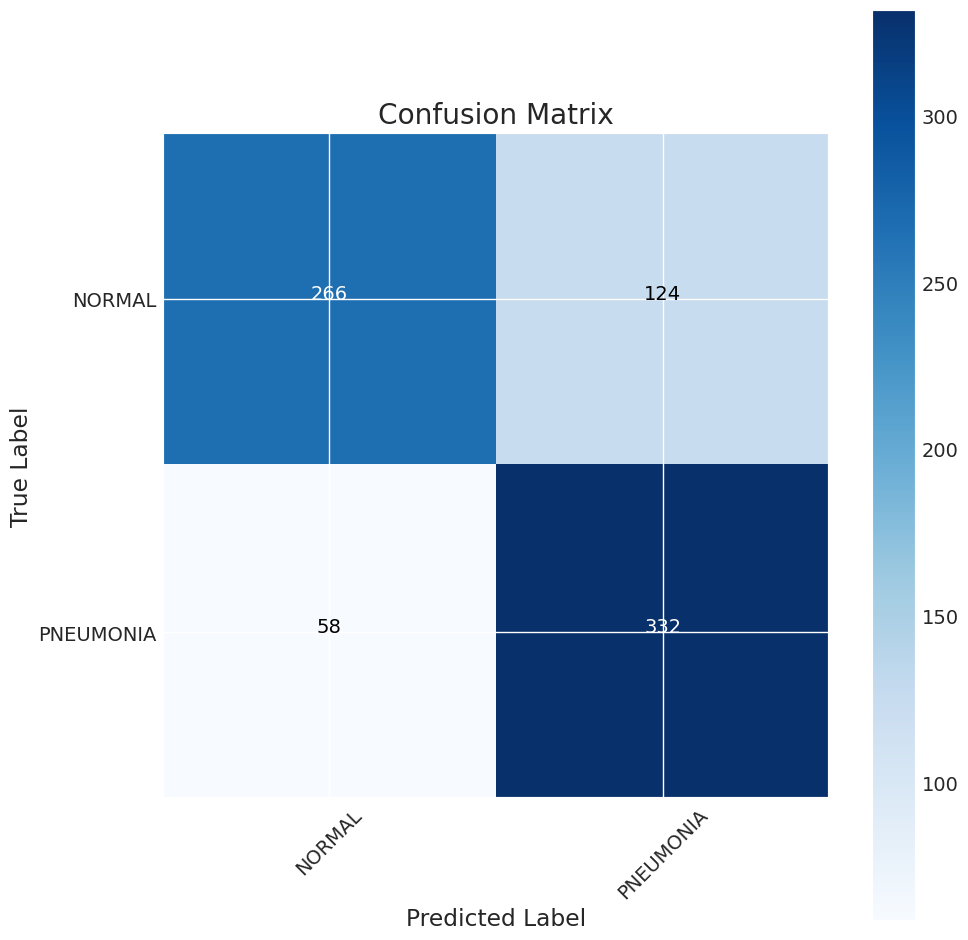

              precision    recall  f1-score   support

      NORMAL       0.82      0.68      0.75       390
   PNEUMONIA       0.73      0.85      0.78       390

    accuracy                           0.77       780
   macro avg       0.77      0.77      0.76       780
weighted avg       0.77      0.77      0.76       780



In [31]:
# Prédictions
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Matrice de confusion
cm = confusion_matrix(test_gen.classes, y_pred)
classes = list(test_gen.class_indices.keys())

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(test_gen.classes, y_pred, target_names=classes))

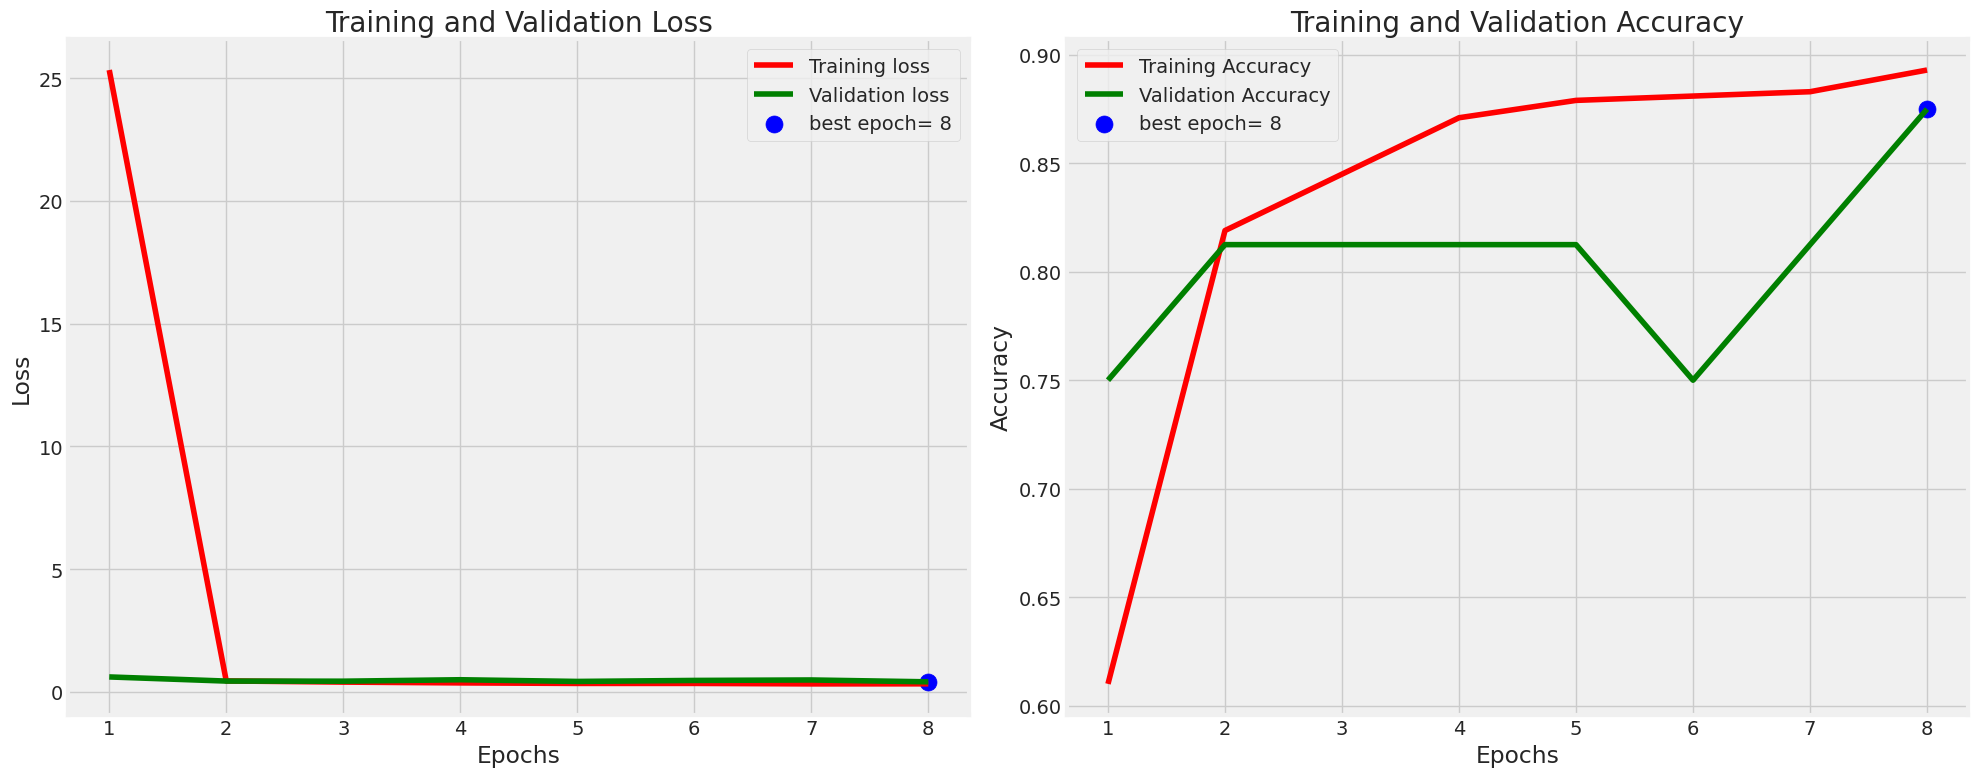

In [32]:
# Affichage de l'historique d'entraînement
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()